In [ ]:
from erasure_simulator import *
import numpy as np
import stim
import sys
import pandas as pd

hookinj_path = r'./gidney_code/src'
sys.path.append(hookinj_path)
from hookinj.gen import NoiseModel
from hookinj._make_circuit import *
# from compute_error_bound import *

from custom_noise import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:

noise_model_obj = SparseIdlingNoiseModel.uniform_depolarizing(0.001)

noise_model_obj.measure_rules['XXXX'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
noise_model_obj.measure_rules['ZZZZ'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
noise_model_obj.measure_rules['YYYYYYY'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
clean_circuit = stim.Circuit.from_file('./circuits/color_code[unitary].stim')
circuit = noise_model_obj.noisy_circuit(clean_circuit)

In [ ]:
import collections

from joblib import Parallel, delayed

def get_noise_obj(p):
    noise_model_obj = NoiseModel.uniform_depolarizing(p)

    noise_model_obj.measure_rules['XXXX'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
    noise_model_obj.measure_rules['ZZZZ'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
    noise_model_obj.measure_rules['YYYYYYY'] = NoiseRule(after={'DEPOLARIZE1': 0}, flip_result=0)
    return noise_model_obj

def get_error_and_success_rate(clean_circuit, e, p, r, num_shots):
    noise_model_obj = get_noise_obj(p)
    circuit = noise_model_obj.noisy_circuit(clean_circuit)
    circuit = remove_errors_from_injection(circuit, 0, r)

    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    # print('Error probability:', p)
    # print('Erasure rate:', e)
    # print('detection_events:', np.sum(detection_events, axis=1).astype(bool).astype(int))
    # print('observable_flips:', observable_flips.T.astype(int))
    
    obs = observable_flips.T.astype(int)

    dets = np.logical_not(np.sum(detection_events, axis=1).astype(bool))

    obs_post = np.where(dets, obs, -1)
    # print(f"{obs=}")
    # print(f"{np.sum(detection_events, axis=1).astype(bool)=}")
    # print(f"{obs_post=}")

    c = collections.Counter(obs_post.flatten())
    successful_shots = num_shots - c[-1]
    if successful_shots > 0:
        err = c[1] / successful_shots
    else:
        err = np.nan

    erasure_success_rate = get_erasure_post_rate(
        circuit, 
        e=1 - (1 - e)**0.5,  # convert to e_star 
        e1=e, 
        e_SPAM = e, 
        r=r, 
        erasure_post_qubits = get_small_patch_qubits(circuit)
    ) if e > 0 else 1
    # get_erasure_post_rate(circuit, e, r=r, erasure_post_qubits=get_small_patch_qubits(circuit))
    return err, (successful_shots / num_shots * erasure_success_rate)


clean_circuit = stim.Circuit.from_file('./circuits/color_code[unitary].stim')
injection_type = 'color'
# noisy_cultivation = stim.Circuit.from_file('./circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim')
# clean_circuit = remove_errors_from_injection(noisy_cultivation, np.inf, 0)
r=2
num_shots = 100_000_000
num_shots_dict = {
    'color': 1_000_000,
    'cultivation': 10_000_000
}

ep_list = [
    (0, 0.001),
    (1e-3, 1e-4),
    (4e-3, 1e-4),
    (1e-2, 1e-4),
]

# df = pd.DataFrame(columns=['injection_type', 'p', 'e', 'Logical error rate', 'Success rate'])
df = pd.DataFrame()

for injection_type in ['color','cultivation']:
    if injection_type == 'color':
        clean_circuit = stim.Circuit.from_file('./circuits/color_code[unitary].stim')
    if injection_type == 'cultivation':
        noisy_cultivation = stim.Circuit.from_file('./circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3_last_tick.stim')
        clean_circuit = remove_errors_from_injection(noisy_cultivation, np.inf, 0)
    for e, p in ep_list:
        # err, success_rate = get_error_and_success_rate(clean_circuit, e, p, r, num_shots_dict[injection_type])
        N = 800 if injection_type=='cultivation' else 8  # Number of repeated calls
        rates = Parallel(n_jobs=-1)(           # Use all available cores
            delayed(get_error_and_success_rate)(
                clean_circuit, e, p, r, num_shots_dict[injection_type]
            )
            for _ in range(N)
        )

        errors, success_rates = zip(*rates)  # Unpack results into separate lists
        err = np.mean(errors)
        success_rate = np.mean(success_rates)

        print(f"{e=}, {p=}")
        print('Error rate:', err)
        print('success rate:', success_rate)
        new_row = {
            'injection_type': injection_type,
            'pe': p,
            'e': e,
            'logical_err': err, 
            'success_rate': success_rate,
            'distance': 3,
            'std_err': 1.96 * np.sqrt(err * (1 - err) / (N*num_shots) ),
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    # print('Erasure success rate:', get_erasure_post_rate(circuit, e, r=r, erasure_post_qubits=get_small_patch_qubits(circuit)))

results = df
results.head(10)


e=0, p=0.001
Error rate: 0.0005794309638746031
success rate: 0.7949579999999999
e=0.001, p=0.0001
Error rate: 4.873436272583823e-05
success rate: 0.7216787037512312
e=0.004, p=0.0001
Error rate: 5.116539673586172e-05
success rate: 0.29011610195941023
e=0.01, p=0.0001
Error rate: 4.962833554733214e-05
success rate: 0.04650214978865463


# hybrid simulations

In [ ]:
immune_qubits = {2, 3, 4, 5}
p_e = 1e-4
new_circuit = stim.Circuit()
for operation in circuit:
    print(operation)
    noisy_operation = (
        stim.GateData(operation.name).is_noisy_gate 
        and (operation.num_measurements==0 or len(operation.gate_args_copy()) > 0)
        )
    print(noisy_operation)
    if not noisy_operation:
        new_circuit.append(operation)
        continue
    for target_group in operation.target_groups():
        print(target_group)
        if all([int(qubit.qubit_value) in immune_qubits for qubit in target_group]):
            # print('immune qubit')
            new_op = stim.CircuitInstruction(operation.name, target_group, gate_args=[p_e])
            new_circuit.append(new_op)
        else:
            # print('non-immune qubit')
            new_op = stim.CircuitInstruction(operation.name, target_group, gate_args=operation.gate_args_copy())
            new_circuit.append(new_op)

    # if stim.GateData(gate.name).is_noisy_gate and (gate.num_measurements==0 or len(gate.gate_args_copy()) > 0)
    # operation.targets_copy()
print(new_circuit)

QUBIT_COORDS(0, 0) 0
False
QUBIT_COORDS(0, 1) 1
False
QUBIT_COORDS(1, 0) 2
False
QUBIT_COORDS(1, 1) 3
False
QUBIT_COORDS(1, 2) 4
False
QUBIT_COORDS(1, 3) 5
False
QUBIT_COORDS(2, 0) 6
False
QUBIT_COORDS(2, 1) 7
False
QUBIT_COORDS(2, 2) 8
False
QUBIT_COORDS(2, 3) 9
False
QUBIT_COORDS(3, 0) 10
False
QUBIT_COORDS(3, 1) 11
False
QUBIT_COORDS(3, 2) 12
False
QUBIT_COORDS(4, 0) 13
False
QUBIT_COORDS(4, 1) 14
False
RX 7 10 12 3 2 4 14 0 5 13
False
R 11 8 6
False
X_ERROR(0.001) 11 8 6
True
[stim.GateTarget(11)]
non-immune qubit
[stim.GateTarget(8)]
non-immune qubit
[stim.GateTarget(6)]
non-immune qubit
Z_ERROR(0.001) 7 10 12 3 2 4 14 0 5 13
True
[stim.GateTarget(7)]
non-immune qubit
[stim.GateTarget(10)]
non-immune qubit
[stim.GateTarget(12)]
non-immune qubit
[stim.GateTarget(3)]
immune qubit
[stim.GateTarget(2)]
immune qubit
[stim.GateTarget(4)]
immune qubit
[stim.GateTarget(14)]
non-immune qubit
[stim.GateTarget(0)]
non-immune qubit
[stim.GateTarget(5)]
immune qubit
[stim.GateTarget(13)]
non-i

In [ ]:
def get_error_and_success_rate_non_erasure(circuit, num_shots):
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    obs = observable_flips.T.astype(int)

    dets = np.logical_not(np.sum(detection_events, axis=1).astype(bool))

    obs_post = np.where(dets, obs, -1)

    c = collections.Counter(obs_post.flatten())
    successful_shots = num_shots - c[-1]
    if successful_shots > 0:
        err = c[1] / successful_shots
    else:
        err = np.nan

    # add this somtim
    # erasure_success_rate = get_erasure_post_rate(
    #     circuit, 
    #     e=1 - (1 - e)**0.5,  # convert to e_star 
    #     e1=e, 
    #     e_SPAM = e, 
    #     r=r, 
    #     erasure_post_qubits = get_small_patch_qubits(circuit)
    # ) if e > 0 else 1
    return err, (successful_shots / num_shots)# * erasure_success_rate)

In [ ]:
cultivation_file = './circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3_last_tick.stim'

noisy_cultivation = stim.Circuit.from_file(cultivation_file)
circuit = noisy_cultivation

# immune_qubits = {0, 1, 2, 3, 8, 9} # 6-qubit result from before
immune_qubits = {0, 1, 2, 3, 4, 5, 8, 9, 12} # full 9 qubits
new_circuit = immunify_qubits(circuit, immune_qubits, p_e=1e-4)

# new_circuit

In [ ]:

e = 1e-3

immune_qubits_str = {str(qubit) for qubit in immune_qubits}

erasure_success_rate = get_erasure_post_rate(
        new_circuit, 
        e=1 - (1 - e)**0.5,  # convert to e_star 
        e1=e, 
        e_SPAM = e, 
        r=np.inf, 
        erasure_post_qubits = immune_qubits_str
)

num_shots = 500_000_000
old_err, old_SR = get_error_and_success_rate_non_erasure(circuit, num_shots)
new_err, new_SR = get_error_and_success_rate_non_erasure(new_circuit, num_shots)
new_SR = new_SR * erasure_success_rate
print(f"Old error rate: {old_err:.2e}, Success rate: {old_SR:.3f}")
print(f"New error rate: {new_err:.2e}, Success rate: {new_SR:.3f}")

Old error rate: 3.55e-07, Success rate: 0.687
New error rate: 1.45e-08, Success rate: 0.602


In [ ]:
new_err_9 = new_err
new_SR_9 = new_SR

# Plot

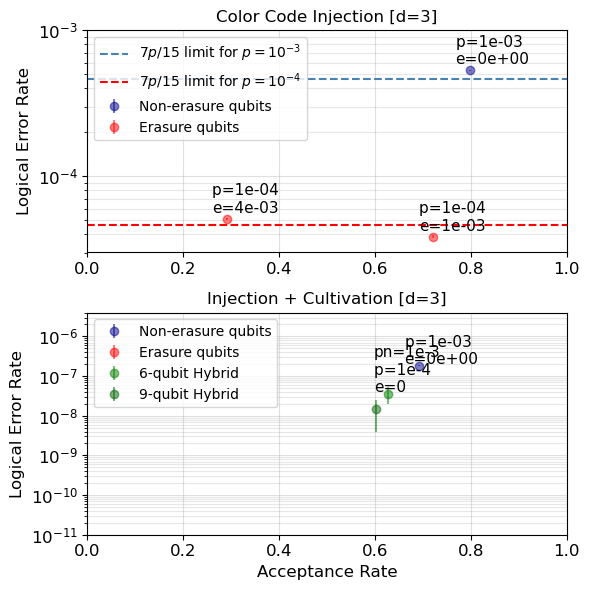

In [ ]:
import matplotlib.pyplot as plt
from datetime import date

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
from itertools import cycle
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

label_fontsize = 12
title_fontsize = 12
legend_fontsize = 10

theory_coef_dict = {
    ('color', 3): 7,
    ('cultivation', 3): 0,
}

x_axis = "success_rate" # attempts_per_shot

d=3
results['attempts_per_shot'] = 1 / results['success_rate']

# each plot is for different injection type

# add different colors for different injection types
# colors = ['b', '#1f77b4', 'darkblue', 'r', 'orange', '#d62728']
colors = [
    # '#7f7f7f',   # Gray',
    # '#87CEFA',  # Light Blue
    '#00008B',  # Dark Blue
    # '#A52A2A',  # Brown
    'r',  # Light Red
    # 'orange'   # Dark Red
]
color_generator = cycle(colors)
color_dict = dict(zip(results['injection_type'].unique(), colors))

labels = [
    'Non-erasure qubits',
    'Erasure qubits',
    # 'Faulty erasure checks'
]
label_generator = cycle(labels)

for i, injection_type in enumerate(['color', 'cultivation']):
    # Filter for injection type
    ax = axes[i]

    df_filtered_list = []
    df_filtered_list.append(
        results[(results['injection_type'] == injection_type) & (results['distance'] == d) & (results['e'] == 0)]
    )

    df_filtered_list.append(
        results[(results['injection_type'] == injection_type) & (results['distance'] == d) & (results['e'] != 0)]
    )

    for df_filtered in df_filtered_list:
        ax.errorbar(
            df_filtered[x_axis], 
            df_filtered['logical_err'], 
            yerr=1.96 * df_filtered['std_err'], 
            fmt='o', 
            color=next(color_generator), # color=color_dict[injection_type],
            label=next(label_generator), 
            alpha=0.5
        )
    
        # annotate all points
        for i, row in df_filtered.iterrows():
            # if row['qubit_type'] == 'fullerasure':
            ax.annotate(f'p={row["pe"]:.0e} \ne={row["e"]:.0e}',  (row[x_axis]-0.03, row["logical_err"]*1.1), fontsize=11)
            # if row['qubit_type'] == 'noerasure':
            #     ax.annotate(f'p={row["p"]:.1e}',  (row[x_axis], row["logical_err"]))
    

    th_coef = theory_coef_dict[(injection_type,d)]
    if injection_type=='color':
        p = 1e-3
        ax.hlines(
            th_coef*p/15, 0, 1e5, 
            colors='steelblue', #'coral' if injection_type=='hook' else 'deepskyblue', slategray
            linestyles='dashed', 
            label=f'${th_coef}p/15$ limit for $p=10^{{-3}}$'
        )
        p = 1e-4
        ax.hlines(
            th_coef*p/15, 0, 1e5, 
            colors='r',  # 'r' if injection_type=='hook' else '', 
            linestyles='dashed', 
            label=f'${th_coef}p/15$ limit for $p=10^{{-4}}$'
        )


    
    if d==2:
        ax.set_xlim(1, 4)
    elif d==3 and x_axis == "attempts_per_shot":
        ax.set_xlim(1, 4)
        ax.set_xscale('log')
    elif d==3 and x_axis == 'success_rate':
        ax.set_xlim(0, 1)
    ylimits = [3e-5, 1e-3] if injection_type=='color' else [1e-11,4e-6]
    ax.set_ylim(ylimits)
    ax.set_yscale('log')
    ax.set_ylabel('Logical Error Rate', fontsize = label_fontsize)

    title = f"Color Code Injection [d={d}]" if injection_type == 'color' else f"Injection + Cultivation [d={d}]"
    ax.set_title(title, fontsize = title_fontsize)
    ax.grid(which='major', alpha=0.4)
    ax.grid(which='minor', alpha=0.3)
    ax.legend(fontsize = legend_fontsize)
    ax.tick_params(labelsize=label_fontsize)

# axes[1].set_xlabel(x_axis.replace('_', ' ').title(), fontsize = label_fontsize)
axes[1].set_xlabel("Acceptance rate".replace('_', ' ').title(), fontsize = label_fontsize)

## Add the Hybrid point
axes[1].errorbar(new_SR_6, new_err_6, yerr=1.96 * np.sqrt(new_err_6/500e6), fmt='o', color='green', label='6-qubit Hybrid', alpha=0.5)
axes[1].errorbar(new_SR_9, new_err_9, yerr=1.96 * np.sqrt(new_err_9/500e6), fmt='o', color='darkgreen', label='9-qubit Hybrid', alpha=0.5)
axes[1].legend(fontsize = legend_fontsize)
# Anotate the first hybrid point
axes[1].annotate(f'pn=1e-3\np=1e-4 \ne=1e-3',  (new_SR_6-0.03, new_err_6*1.1), fontsize=11)

fig.tight_layout()
plt.savefig(f'./out/{date.today()}-injection_comparison.svg')
plt.show()

# Finding best 8 qubits

In [220]:
from itertools import combinations

def eight_qubit_set_cover_for_faults(fault_mechanisms, universe=set(range(13))):
    """
    Find the best set of 8 qubits that covers the maximum number of fault mechanisms
    
    Args:
        fault_mechanisms: List of fault mechanisms to cover
        universe: The universe of qubit indices (default: 0-12)
        
    Returns:
        A set representing the best 8-qubit cover
    """
    best_coverage_count = 0
    best_eight = None
    
    print(f"Evaluating all possible sets of 8 qubits from {len(universe)} qubits...")
    
    # Generate all possible combinations of 8 qubits
    for eight_qubits in combinations(universe, 8):
        immune_qubits = set(eight_qubits)
        
        # Count how many faults this set of qubits covers
        coverage_count = 0
        for fault in fault_mechanisms:
            if coverage(fault, immune_qubits):
                coverage_count += 1
        
        if coverage_count > best_coverage_count:
            best_coverage_count = coverage_count
            best_eight = immune_qubits
            print(f"New best: {best_eight}, covers {coverage_count}/{len(fault_mechanisms)} faults ({coverage_count/len(fault_mechanisms):.2%})")
    
    print(f"Final result: {best_eight}, covers {best_coverage_count}/{len(fault_mechanisms)} faults ({best_coverage_count/len(fault_mechanisms):.2%})")
    
    return best_eight


In [222]:
eight_qubit_set_cover_for_faults(fault_mechanisms, set(range(circuit.num_qubits)))

Evaluating all possible sets of 8 qubits from 15 qubits...
New best: {0, 1, 2, 3, 4, 5, 6, 7}, covers 195414/232506 faults (84.05%)
New best: {0, 1, 2, 3, 4, 5, 6, 9}, covers 209874/232506 faults (90.27%)
New best: {0, 1, 2, 3, 4, 5, 7, 9}, covers 210882/232506 faults (90.70%)
New best: {0, 1, 2, 3, 4, 5, 8, 9}, covers 232218/232506 faults (99.88%)
Final result: {0, 1, 2, 3, 4, 5, 8, 9}, covers 232218/232506 faults (99.88%)


{0, 1, 2, 3, 4, 5, 8, 9}